In [1]:
import mesa

# Data visualization tools.
import seaborn as sns

# Has multi-dimensional arrays and matrices. Has a large collection of
# mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

In [2]:
from cacheable_model import CacheableModel

In [3]:
import cacheable_model

In [4]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.pop(
            cellmates.index(self)
        )  # Ensure agent is not giving money to itself
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
            if other == self:
                print("I JUST GAVE MONEY TO MYSELF HEHEHE!")

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        super().__init__()
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [5]:
model = MoneyModel(100, 10, 10)


In [6]:
cacheable_model = CacheableModel(model, "a", 10000, None)

In [7]:
for i in range(10000):
    print(i)
    cacheable_model.model.step()
    cacheable_model.cache()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CALLED
self.model._steps=100
 TEST self.model._steps=100
 TEST self._cache_interval=100
      Gini
0   0.0000
1   0.2822
2   0.3666
3   0.4510
4   0.5058
..     ...
95  0.6584
96  0.6582
97  0.6362
98  0.6440
99  0.6602

[100 rows x 1 columns]
3
model_file='output_dir/model_data_001.parquet'
absolute_path='/mnt/c/wsl/github/mesa-forked/mesa/output_dir/model_data_001.parquet'
Saving model to output_dir/model_data_001.parquet
Saving agent to output_dir/agent_data_001.parquet
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157


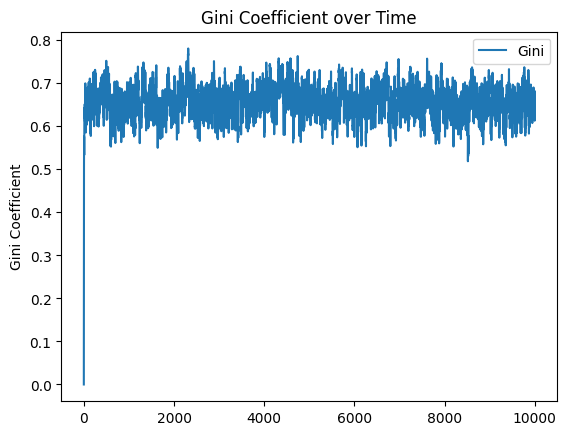

In [8]:

gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

In [9]:
gini

,Gini
0,0.0000
1,0.2822
2,0.3666
3,0.4510
4,0.5058
...,...
9995,0.6358
9996,0.6332
9997,0.6128
9998,0.6314


In [10]:
import pyarrow.parquet as pq
import pandas as pd
import glob

# Get a list of all Parquet files
model_files = glob.glob('output_dir/model_data_*.parquet')
agent_files = glob.glob('output_dir/agent_data_*.parquet')

# Initialize lists to hold dataframes
model_dfs = []
agent_dfs = []

# Read and append each file to the list
for model_file in model_files:
    table = pq.read_table(model_file)
    df = table.to_pandas()
    model_dfs.append(df)

for agent_file in agent_files:
    table = pq.read_table(agent_file)
    df = table.to_pandas()
    agent_dfs.append(df)

# Concatenate all DataFrames
model_df = pd.concat(model_dfs, ignore_index=True)
agent_df = pd.concat(agent_dfs, ignore_index=True)

# Display the combined DataFrames
print(model_df)


        Gini
0     0.0000
1     0.2822
2     0.3666
3     0.4510
4     0.5058
...      ...
9995  0.6358
9996  0.6332
9997  0.6128
9998  0.6314
9999  0.6778

[10000 rows x 1 columns]


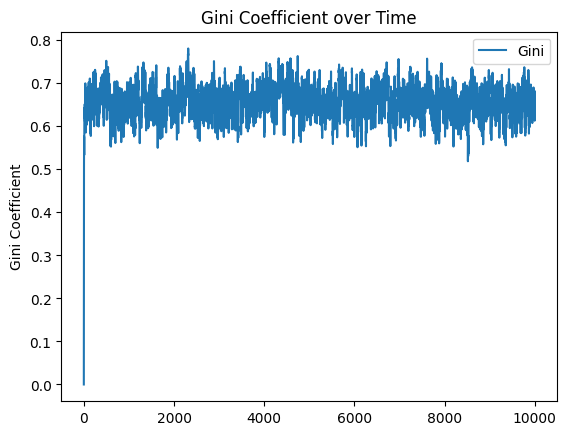

In [11]:
model_df
g = sns.lineplot(data=model_df)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

In [12]:
model_df

,Gini
0,0.0000
1,0.2822
2,0.3666
3,0.4510
4,0.5058
...,...
9995,0.6358
9996,0.6332
9997,0.6128
9998,0.6314


In [13]:
model_df[:105]

,Gini
0,0.0000
1,0.2822
2,0.3666
3,0.4510
4,0.5058
...,...
100,0.6794
101,0.6842
102,0.6756
103,0.6532


In [14]:
gini[:101]

,Gini
0,0.0000
1,0.2822
2,0.3666
3,0.4510
4,0.5058
...,...
96,0.6582
97,0.6362
98,0.6440
99,0.6602


In [15]:
model_files

['output_dir/model_data_001.parquet',
 'output_dir/model_data_002.parquet',
 'output_dir/model_data_003.parquet',
 'output_dir/model_data_004.parquet',
 'output_dir/model_data_005.parquet',
 'output_dir/model_data_006.parquet',
 'output_dir/model_data_007.parquet',
 'output_dir/model_data_008.parquet',
 'output_dir/model_data_009.parquet',
 'output_dir/model_data_010.parquet',
 'output_dir/model_data_011.parquet',
 'output_dir/model_data_012.parquet',
 'output_dir/model_data_013.parquet',
 'output_dir/model_data_014.parquet',
 'output_dir/model_data_015.parquet',
 'output_dir/model_data_016.parquet',
 'output_dir/model_data_017.parquet',
 'output_dir/model_data_018.parquet',
 'output_dir/model_data_019.parquet',
 'output_dir/model_data_020.parquet',
 'output_dir/model_data_021.parquet',
 'output_dir/model_data_022.parquet',
 'output_dir/model_data_023.parquet',
 'output_dir/model_data_024.parquet',
 'output_dir/model_data_025.parquet',
 'output_dir/model_data_026.parquet',
 'output_dir

In [16]:
model_df

,Gini
0,0.0000
1,0.2822
2,0.3666
3,0.4510
4,0.5058
...,...
9995,0.6358
9996,0.6332
9997,0.6128
9998,0.6314


In [17]:
gini

,Gini
0,0.0000
1,0.2822
2,0.3666
3,0.4510
4,0.5058
...,...
9995,0.6358
9996,0.6332
9997,0.6128
9998,0.6314
